# Restaurant-Application

This application aims to helps you to find a place for your next restaurant!

## Setup

### Installs / Imports

In [ ]:
#Install all the necessary libraries

!pip install sparql-dataframe
!pip install folium

In [129]:
#Import all the necessary libraries
import folium 
from folium.plugins import HeatMap
import sparql_dataframe

### Graph DB

#### Install Graph DB
- Just follow the course guidelines
- Create an empty repository and run the query in the following code block:

```SPARQL
PREFIX geosparql: <http://www.ontotext.com/plugins/geosparql#>

INSERT DATA {
  [] geosparql:enabled "true" .
  [] geosparql:ignoreErrors "true" .
  [] geosparql:maxBufferedDocs "3000" .
  [] geosparql:ramBufferSizeMB "128.0" .
  [] geosparql:prefixTree "geohash" .
}
```

- This query enables the features of GeoSparql, which we use to query distances for the first part
- Now get the sparql endpoint of your repository and past it below:

In [178]:
ENDPOINT = "http://DESKTOP-9S7BIOI:7200/repositories/testing"

#### Load Data into GraphDB:

You will find 2 kinds of data_sets with our submission of this project. 

Dataset names that contain a 'WTK' are needed for part 1 but they take a lot of time to load into GraphDB because GeoSparql needs to index them.

Datasets without a 'WTK' can be imported quite quickly we still provided some to choose from.

We recommend you import netherlands.ttl for the first part to work and as many amsterdam_wtk_x_y.ttl as your computer can handle. This will allow you to see the Heatmap for the whole netherlands and to query close restaurants in amsterdam (at least some of them).

netherlands_wtk.ttl is still provided and it works but importhing this takes a very very very insanely long time.

### Queries

In [179]:
def fetchCloseRestaurants(lat, long, radius):
    q = """
  PREFIX rm: <http://www.restaurant-map.com/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
prefix geof: <http://www.opengis.net/def/function/geosparql/>
PREFIX uom: <http://www.opengis.net/def/uom/OGC/1.0/>

SELECT ?restaurant ?name ?distance ?geo ?cuisine{{
  ?restaurant a rm:Restaurant ;
    geo:asWKT ?geo .
   ?restaurant rm:hasLabel ?name .
   ?restaurant rm:servesCuisine ?cuisine .
    BIND(geof:distance("Point({long} {lat})"^^<http://www.opengis.net/ont/geosparql#wktLiteral>, ?geo, uom:metre) AS ?distance)
    FILTER(?distance < "{radius}"^^xsd:double)
}} ORDER BY ASC(?distance)
""".format(long=long, lat=lat, radius=radius)

    return sparql_dataframe.get(ENDPOINT, q)


def fetchHeatmap(cuisine):
    # Fetch Restaurants of Cuisine

    q = """
    PREFIX rm: <http://www.restaurant-map.com/>
        PREFIX geo: <http://www.opengis.net/ont/geosparql#>
SELECT ?lat ?long {{
    ?restaurant a rm:Restaurant .
    ?restaurant rm:hasLabel ?name .
    ?restaurant rm:servesCuisine rm:{cuisine} .
    ?restaurant rm:hasLong ?long .    
    ?restaurant rm:hasLat ?lat .

}}

    """.format(cuisine=cuisine)

    return sparql_dataframe.get(ENDPOINT, q)


### Visualisations

In [174]:
def getProximityMap(data, lat, long):
    m = folium.Map(location=[lat, long], zoom_start=4)

    restaurants_cords = data.join(data.geo.str.extract('Point\((?P<long>\S+) (?P<lat>\S+)\)').astype(float))

    for index, row in restaurants_cords.iterrows():
        folium.CircleMarker(
        location=[row['lat'], row['long']],
        radius =3,
        popup= row['name'],
        color="#3186cc",
        fill=True,
        fill_color="#3186cc",
        ).add_to(m)

    #chosen location
    folium.CircleMarker(
        location=[lat, long],
        radius =3,
        popup= "My Locatio",
        color="#FF00FF",
        fill=True,
        fill_color="#FF00FF",
    ).add_to(m)

    return m

def plotCompetition(data):
    data['cuisine'].value_counts()[:10].plot.barh(title="Your competition")


In [169]:
def getHeatMap(data, blur, radius):
    data = data[data['lat'].notna()]
    data = data[data['long'].notna()]

    #Make the list of Lat an Lng
    lat = data.lat.tolist()
    lng = data.long.tolist()

    #Create the Map
    map = folium.Map(
        location=[data.lat.mean(), data.long.mean()],
        zoom_start=12,
    )
    HeatMap(list(zip(lat, lng)),radius=radius,
        blur=blur).add_to(map)

    return map

## Application

### Part 1: Already have a location in mind? Find out what you should cook:

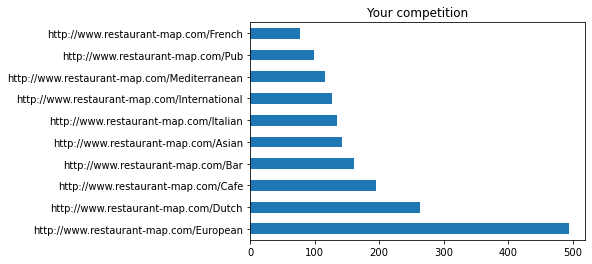

In [182]:
###SETTINGS 
LAT = 52.387880 #Latitude of your location
LONG =  4.835570 #Longitude of your location

RADIUS = 6000 #Radius to look for competition in meter


###DONT TOUCH
data = fetchCloseRestaurants(LAT, LONG, RADIUS)
plotCompetition(data)
m = getProximityMap(data, LAT, LONG)
m

### Part 2: Already a cuisine in mind? Find out where you should open your restaurant:

In [180]:
###SETTINGS
CUISINE = "Dutch" # also try Dutch, European, Arabic etc...

###STYLING
HEAT_RADIUS = 15 
HEAT_BLUR = 15

###DONT TOUCH
data = fetchHeatmap(CUISINE)

map = getHeatMap(data, HEAT_BLUR, HEAT_RADIUS)
map
